# 第9章: RNN, CNN

## 80. ID番号への変換

問題51で構築した学習データ中の単語にユニークなID番号を付与したい．学習データ中で最も頻出する単語に1，2番目に頻出する単語に2，……といった方法で，学習データ中で2回以上出現する単語にID番号を付与せよ．そして，与えられた単語列に対して，ID番号の列を返す関数を実装せよ．ただし，出現頻度が2回未満の単語のID番号はすべて0とせよ．

In [1]:
# データのダウンロード
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

--2021-07-13 08:13:19--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  25.8MB/s    in 1.1s    

2021-07-13 08:13:21 (25.8 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# データの読込
df = pd.read_csv('./newsCorpora.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

# データの抽出
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

# データの分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])


In [3]:
from collections import defaultdict
import string

# 単語の頻度集計
d = defaultdict(int)  # 0で初期化された辞書作成
table = str.maketrans(string.punctuation, ' '*len(string.punctuation))  # 記号をスペースに置換するテーブル
for text in train['TITLE']:
  for word in text.translate(table).lower().split():
    d[word] += 1

d = sorted(d.items(), key=lambda x:x[1], reverse=True)  # 辞書のキーの値でソート
word2id = {}
# 単語ID辞書の作成
# 出現頻度が2回以上の単語を登録
for i, (word, cnt) in enumerate(d):
  if cnt > 1:
    word2id.update({word : i+1})

print(f'ID数: {len(set(word2id.values()))}\n')
print('---頻度上位20語---')
for key in list(word2id)[:20]:
    print(f'{key}: {word2id[key]}')

ID数: 7616

---頻度上位20語---
to: 1
s: 2
in: 3
the: 4
of: 5
for: 6
on: 7
as: 8
update: 9
us: 10
and: 11
a: 12
1: 13
with: 14
at: 15
2: 16
is: 17
after: 18
new: 19
up: 20


In [4]:
def tokenizer(text, word2id=word2id, unk=0):
  """ 入力テキストをスペースで分割しID列に変換(辞書になければunkで指定した数字を設定)"""
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))

  # 辞書オブジェクトのget()メソッドを使うと、キーが存在しない場合にエラーを発生させずに任意の値（デフォルト値）を取得できる。
  return [word2id.get(word, unk) for word in text.lower().translate(table).split()]  

In [5]:
# 確認
text = train.iloc[1, train.columns.get_loc('TITLE')]
print(f'テキスト: {text}')
print(f'ID列: {tokenizer(text)}')

テキスト: FOREX-Dollar rises on US rate speculation after Yellen comments
ID列: [62, 46, 100, 7, 10, 111, 1124, 18, 131, 357]


## 81. RNNによる予測
ID番号で表現された単語列$\boldsymbol{x} = (x_1, x_2, \dots, x_T)$がある．ただし，$T$は単語列の長さ，$x_t \in \mathbb{R}^{V}$は単語のID番号のone-hot表記である（$V$は単語の総数である）．再帰型ニューラルネットワーク（RNN: Recurrent Neural Network）を用い，単語列$\boldsymbol{x}$からカテゴリ$y$を予測するモデルとして，次式を実装せよ．


$$
\overrightarrow h_0 = 0,\\
\overrightarrow h_t = {\rm \overrightarrow{RNN}}(\mathrm{emb}(x_t), \overrightarrow h_{t-1}), \\
y = {\rm softmax}(W^{(yh)} \overrightarrow h_T + b^{(y)})
$$


ただし，$\mathrm{emb}(x) \in \mathbb{R}^{d_w}$は単語埋め込み（単語のone-hot表記から単語ベクトルに変換する関数），$\overrightarrow h_t \in \mathbb{R}^{d_h}$は時刻$t$の隠れ状態ベクトル，${\rm \overrightarrow{RNN}}(x,h)$は入力$x$と前時刻の隠れ状態$h$から次状態を計算するRNNユニット，$W^{(yh)} \in \mathbb{R}^{L \times d_h}$は隠れ状態ベクトルからカテゴリを予測するための行列，$b^{(y)} \in \mathbb{R}^{L}$はバイアス項である（$d_w, d_h, L$はそれぞれ，単語埋め込みの次元数，隠れ状態ベクトルの次元数，ラベル数である）．RNNユニット${\rm \overrightarrow{RNN}}(x,h)$には様々な構成が考えられるが，典型例として次式が挙げられる．

$$
{\rm \overrightarrow{RNN}}(x,h) = g(W^{(hx)} x + W^{(hh)}h + b^{(h)})
$$

ただし，$W^{(hx)} \in \mathbb{R}^{d_h \times d_w}，W^{(hh)} \in \mathbb{R}^{d_h \times d_h}, b^{(h)} \in \mathbb{R}^{d_h}$はRNNユニットのパラメータ，$g$は活性化関数（例えば$\tanh$やReLUなど）である．

なお，この問題ではパラメータの学習を行わず，ランダムに初期化されたパラメータで$y$を計算するだけでよい．次元数などのハイパーパラメータは，$d_w = 300, d_h=50$など，適当な値に設定せよ（以降の問題でも同様である）．

One-Hotベクトルなので、次元数は単語数と同じ$\mathbb{R}^{V}$

nn.Embeddingについて  
　入力は，単語IDの並びです。出力は，各単語の埋め込みベクトルです。  
　nn.Embeddingは，同一バッチ内で系列長が異なるとエラーを吐く。paddingは，系列長が足りない部分を何かしらの値で埋めることです。  
　これでnn.Embedding()の入力とできますが，paddingした0というのはダミーのIDであって，何かしらの単語を表すものではありません．0に対しては埋め込みベクトルも計算して欲しくないので，オプションのpadding_idxを用いて無視するようにします．また，ダミーIDのために単語IDが1つ余分に消費されるため，宣言時の語彙サイズも1つ大きくする必要があります．

In [7]:
import torch
from torch import nn

class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size):
    super().__init__()
    self.hidden_size = hidden_size  # hidden_sizeが「dh」
    # 埋め込み層にはnn.Embeddingを使います。この層は、単語IDを与えるとone-hotベクトルに変換した後、指定したサイズ（emb_size）のベクトルに変換します。
    self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)  # vocab_sizeが「V」、emb_sizeが「dw」、padding_idxが単語IDの最後のID番号+1の値
    # RNNの入力はエンベディングベクトルと隠れ状態ベクトル。
      # batch_first – If True, then the input and output tensors are provided as (batch, seq, feature).
    self.rnn = nn.RNN(emb_size, hidden_size, nonlinearity='tanh', batch_first=True)
    # RNNの出力の隠れ状態ベクトルを、アフィン変換してカテゴリyの予測に使用。
    self.fc = nn.Linear(hidden_size, output_size)  # output_sizeが「L」(ラベル数)

  def forward(self, x):
    self.batch_size = x.size()[0]  # バッチ内のデータ数
    hidden = self.init_hidden()  # h0のゼロベクトルを作成
    # ここスタック使った方がまとまりそう
    emb = self.emb(x)  # 入力の単語IDをエンベディングベクトルに
    # emb.size() = (batch_size, seq_len, emb_size) # (バッチ内のデータ数, 文字列中の単語数、単語ベクトル)
    # outは各時刻の隠れ状態(各単語に対応する隠れ状態)を保持、hiddenは最後の時刻の隠れ状態
    out, hidden = self.rnn(emb, hidden)
    # out.size() = (batch_size, seq_len, hidden_size)
    out = self.fc(out[:, -1, :])  # 最後の隠れ状態ベクトルだけ使う？
    # out.size() = (batch_size, output_size)  # output_size = 4（カテゴリ数）
    return out

  def init_hidden(self):
    hidden = torch.zeros(1, self.batch_size, self.hidden_size)
    return hidden

In [8]:
# テキストとラベルを受け取り、テキストを指定したtokenizerでID化した後、それぞれをTensor型で出力する機能を持たせます。
from torch.utils.data import Dataset

class CreateDataset(Dataset):
  def __init__(self, X, y, tokenizer):
    self.X = X
    self.y = y
    self.tokenizer = tokenizer

  def __len__(self):  # len(Dataset)で返す値を指定
    return len(self.y)

  def __getitem__(self, index):  # Dataset[index]で返す値を指定
    text = self.X[index]
    inputs = self.tokenizer(text)

    return {  # 何でtorchの型にしてる？
      'inputs': torch.tensor(inputs, dtype=torch.int64),
      'labels': torch.tensor(self.y[index], dtype=torch.int64)
    }

In [9]:
# ラベルベクトルの作成
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = train['CATEGORY'].map(lambda x: category_dict[x]).values
y_valid = valid['CATEGORY'].map(lambda x: category_dict[x]).values
y_test = test['CATEGORY'].map(lambda x: category_dict[x]).values

# Datasetの作成
dataset_train = CreateDataset(train['TITLE'].values, y_train, tokenizer)  # train['TITLE']:記事, y_train:カテゴリID
dataset_valid = CreateDataset(valid['TITLE'].values, y_valid, tokenizer)
dataset_test = CreateDataset(test['TITLE'].values, y_test, tokenizer)

print(f'len(Dataset)の出力: {len(dataset_train)}')  # 10684個の記事
print('Dataset[index]の出力:')  # index番目の記事の各単語をid化したもの
for var in dataset_train[1]:  # 記事の１つ目をgetitem処理した出力  # 辞書オブジェクトをそのままfor文で回すとキーkeyが取得できる
  print(f'  {var}: {dataset_train[1][var]}')


len(Dataset)の出力: 10672
Dataset[index]の出力:
  inputs: tensor([  62,   46,  100,    7,   10,  111, 1124,   18,  131,  357])
  labels: 0


本問では学習しないため、Datasetからinputsをモデルに与え、Softmax後にそのまま出力を確認します。

In [10]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 先頭10件の予測値取得
for i in range(10):
  X = dataset_train[i]['inputs']  # i番目の記事テキストを(getitem()した)ID化したもの
  print(torch.softmax(model(X.unsqueeze(0)), dim=-1))  # modelの入力の形に直してる？バッチとか考えて？

tensor([[0.2164, 0.3061, 0.2080, 0.2694]], grad_fn=<SoftmaxBackward>)
tensor([[0.2356, 0.2726, 0.3749, 0.1168]], grad_fn=<SoftmaxBackward>)
tensor([[0.1859, 0.3389, 0.3283, 0.1469]], grad_fn=<SoftmaxBackward>)
tensor([[0.1873, 0.1672, 0.1889, 0.4566]], grad_fn=<SoftmaxBackward>)
tensor([[0.3070, 0.2561, 0.2476, 0.1893]], grad_fn=<SoftmaxBackward>)
tensor([[0.2353, 0.2380, 0.2122, 0.3145]], grad_fn=<SoftmaxBackward>)
tensor([[0.1423, 0.3673, 0.3633, 0.1271]], grad_fn=<SoftmaxBackward>)
tensor([[0.1128, 0.3928, 0.2680, 0.2264]], grad_fn=<SoftmaxBackward>)
tensor([[0.2379, 0.2690, 0.2927, 0.2003]], grad_fn=<SoftmaxBackward>)
tensor([[0.0955, 0.4474, 0.1739, 0.2833]], grad_fn=<SoftmaxBackward>)


## 82. 確率的勾配降下法による学習

確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題81で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．



In [11]:
from torch.utils.data import DataLoader
import time
from torch import optim

def calculate_loss_and_accuracy(model, dataloader, device=None, loss_fn=None):
    total_loss = len(dataloader)  # バッチ数(損失はバッチ毎(1イテレータ)に1つ求まるので)
    total_data = dataloader.batch_size * len(dataloader)  # ※全データ =  (バッチ内のデータ数) * (バッチ数)
                                  # 予測結果はバッチ毎に、バッチ内のデータ数だけ求まる
    correct, loss = 0, 0

    with torch.no_grad():  # テスト中は伝播記録をしない
        for data in dataloader:
            inputs = data['inputs'].to(device)
            labels = data['labels'].to(device)         
            pred = model(inputs)
            loss += loss_fn(pred, labels).item()  # バッチ内に複数データがあるなら、各データの損失の平均を返す?
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

    return loss / total_loss, correct / total_data

In [ ]:
# dataloaderではなくdataset読み込みver

# def calculate_loss_and_accuracy(model, dataset, device=None, loss_fn=None):
    
#     dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
#     total_loss = len(dataloader)  # バッチ数(損失はバッチ毎(1イテレータ)に1つ求まるので)
#     total_data = dataloader.batch_size * len(dataloader)  # ※全データ =  (バッチ内のデータ数) * (バッチ数)
#                                   # 予測結果はバッチ毎に、バッチ内のデータ数だけ求まる
#     correct, loss = 0, 0

#     with torch.no_grad():  # テスト中は伝播記録をしない
#         for data in dataloader:
#             inputs = data['inputs'].to(device)
#             labels = data['labels'].to(device)         
#             pred = model(inputs)
#             loss += loss_fn(pred, labels).item()  # バッチ内に複数データがあるなら、各データの損失の平均を返す?
#             correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

#     return loss / total_loss, correct / total_data 

現実問題では、常に、過学習を起こしていないかを確認する必要があるので、validation set（検証用のデータセット）を使用しなくてはなりません。

検証時は誤差逆伝播による訓練ステップが存在しないためメモリをそれほど使用しません（勾配を保存する必要がないため）。そこで検証セットには学習セットの2?倍のバッチサイズを使用します。

こうすることにより、より大きなバッチサイズを使用して損失をより迅速に計算することができます。

バッチ内で相関が現れてしまうことや過学習を防ぐには、訓練データをあらかじめシャッフルしておくことが重要です。

一方で、検証のためのデータセットはシャフルの有無は関係なく、損失は同じになります。

余分な時間がかかってしまうので、検証データはシャッフルしないようにしましょう。

In [12]:
def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, collate_fn=None, device=None):
  """モデルの学習を実行し、損失・正解率のログを返す"""
  # デバイスの指定
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
  dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)

  # スケジューラの設定
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for data in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = data['inputs'].to(device)  # 記事テキストを(getitem()した)ID化したもの
      labels = data['labels'].to(device)  # 記事カテゴリをラベル付けしたもの
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 評価モードに設定
    model.eval()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, dataloader_train, device, loss_fn=criterion)  ##
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, dataloader_valid, device, loss_fn=criterion)  ##
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

    # 検証データの損失が3エポック連続で低下しなかった場合は学習終了
    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break

    # スケジューラを1ステップ進める
    scheduler.step()

  return {'train': log_train, 'valid': log_valid}

In [13]:
# import numpy as np
# from matplotlib import pyplot as plt

# def visualize_logs(log):
#   fig, ax = plt.subplots(1, 2, figsize=(15, 5))
#   ax[0].plot(np.array(log['train']).T[0], label='train')
#   ax[0].plot(np.array(log['valid']).T[0], label='valid')
#   ax[0].set_xlabel('epoch')
#   ax[0].set_ylabel('loss')
#   ax[0].legend()
#   ax[1].plot(np.array(log['train']).T[1], label='train')
#   ax[1].plot(np.array(log['valid']).T[1], label='valid')
#   ax[1].set_xlabel('epoch')
#   ax[1].set_ylabel('accuracy')
#   ax[1].legend()
#   plt.show()

In [14]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1 
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 1
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS)

epoch: 1, loss_train: 1.0696, accuracy_train: 0.5483, loss_valid: 1.0932, accuracy_valid: 0.5375, 54.5403sec
epoch: 2, loss_train: 0.9524, accuracy_train: 0.6240, loss_valid: 0.9980, accuracy_valid: 0.6124, 50.9775sec
epoch: 3, loss_train: 0.7637, accuracy_train: 0.7225, loss_valid: 0.8474, accuracy_valid: 0.6912, 50.1116sec
epoch: 4, loss_train: 0.6450, accuracy_train: 0.7684, loss_valid: 0.7590, accuracy_valid: 0.7279, 50.4914sec
epoch: 5, loss_train: 0.5643, accuracy_train: 0.7983, loss_valid: 0.7070, accuracy_valid: 0.7459, 50.2361sec
epoch: 6, loss_train: 0.5020, accuracy_train: 0.8161, loss_valid: 0.6693, accuracy_valid: 0.7526, 50.4088sec
epoch: 7, loss_train: 0.4511, accuracy_train: 0.8338, loss_valid: 0.6380, accuracy_valid: 0.7669, 50.7787sec
epoch: 8, loss_train: 0.4273, accuracy_train: 0.8419, loss_valid: 0.6422, accuracy_valid: 0.7676, 52.2318sec
epoch: 9, loss_train: 0.4087, accuracy_train: 0.8505, loss_valid: 0.6282, accuracy_valid: 0.7736, 53.8458sec
epoch: 10, loss_tra

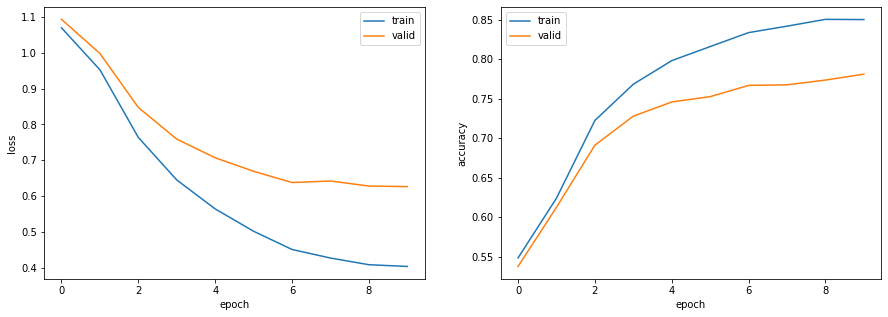

In [15]:
# # ログの可視化
# visualize_logs(log)

In [ ]:
# # 正解率の算出
# _, acc_train = calculate_loss_and_accuracy(model, dataloader_train)
# _, acc_test = calculate_loss_and_accuracy(model, dataloader_test)
# print(f'正解率（学習データ）：{acc_train:.3f}')
# print(f'正解率（評価データ）：{acc_test:.3f}')

## 83. ミニバッチ化・GPU上での学習

問題82のコードを改変し，B事例ごとに損失・勾配を計算して学習を行えるようにせよ（Bの値は適当に選べ）．また，GPU上で学習を実行せよ．



In [31]:
# ラベルベクトルの作成
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = train['CATEGORY'].map(lambda x: category_dict[x]).values
y_valid = valid['CATEGORY'].map(lambda x: category_dict[x]).values
y_test = test['CATEGORY'].map(lambda x: category_dict[x]).values

# Datasetの作成
dataset_train = CreateDataset(train['TITLE'].values, y_train, tokenizer)  # train['TITLE']:記事, y_train:カテゴリID
dataset_valid = CreateDataset(valid['TITLE'].values, y_valid, tokenizer)
dataset_test = CreateDataset(test['TITLE'].values, y_test, tokenizer)

In [22]:
class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size):
    super().__init__()
    self.hidden_size = hidden_size  # hidden_sizeが「dh」
    # 埋め込み層にはnn.Embeddingを使います。この層は、単語IDを与えるとone-hotベクトルに変換した後、指定したサイズ（emb_size）のベクトルに変換します。
    self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)  # vocab_sizeが「V」、emb_sizeが「dw」、padding_idxが単語IDの最後のID番号+1の値
    # RNNの入力はエンベディングベクトルと隠れ状態ベクトル。
      # batch_first – If True, then the input and output tensors are provided as (batch, seq, feature).
    self.rnn = nn.RNN(emb_size, hidden_size, nonlinearity='tanh', batch_first=True)
    # RNNの出力の隠れ状態ベクトルを、アフィン変換してカテゴリyの予測に使用。
    self.fc = nn.Linear(hidden_size, output_size)  # output_sizeが「L」(ラベル数)

  def forward(self, x):
    self.batch_size = x.size()[0]  # バッチ内のデータ数
    hidden = self.init_hidden()  # h0のゼロベクトルを作成
    # ここスタック使った方がまとまりそう
    emb = self.emb(x)  # 入力の単語IDをエンベディングベクトルに
    # emb.size() = (batch_size, seq_len, emb_size) # (バッチ内のデータ数, 文字列中の単語数、単語ベクトル)
    # outは各時刻の隠れ状態(各単語に対応する隠れ状態)を保持、hiddenは最後の時刻の隠れ状態
    out, hidden = self.rnn(emb, hidden)
    # out.size() = (batch_size, seq_len, hidden_size)
    out = self.fc(out[:, -1, :])  # 最後の隠れ状態ベクトルだけ使う？
    # out.size() = (batch_size, output_size)  # output_size = 4（カテゴリ数）
    return out

  def init_hidden(self):
    hidden = torch.zeros(1, self.batch_size, self.hidden_size).to(device)  ##
    return hidden

現在は文ごとに系列長が異なりますが、ミニバッチとしてまとめるには系列長を揃える必要があります。
そこで、複数の文の最大系列長に合わせてパディングする機能を持つPadsequenceクラスを新たに定義します。これをDataloaderの引数collate_fnに与えることで、ミニバッチを取り出すごとに系列長を揃える処理を実現することができます。

In [34]:
class Padsequence():
  """Dataloaderからミニバッチを取り出すごとに最大系列長でパディング"""  # 1つのバッチには、inputsとlabelsの辞書が、バッチ内数だけ並んでいる？
  def __init__(self, padding_idx):
    self.padding_idx = padding_idx

  def __call__(self, batch):
    # 辞書のキー(つまりinputs)の長さ(つまり系列長)が一番長いもの探す
    sorted_batch = sorted(batch, key=lambda x: x['inputs'].shape[0], reverse=True)  # 辞書のリストをキーに関連する値でソートする方法
    sequences = [x['inputs'] for x in sorted_batch]
    # pad_sequenceは長さの違うテンソルを与えると, 短いものの末尾にゼロ埋めを施して次元を揃えてくれる関数
    # 軸の並びを(バッチサイズ×最大シーケンス長×特徴量次元数)にしたければbatch_first=Trueにしましょう
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=self.padding_idx)
    labels = torch.LongTensor([x['labels'] for x in sorted_batch])  # 何で？

    return {'inputs': sequences_padded, 'labels': labels}  # 並び替える必要ある？

In [18]:
from torch.utils.data import DataLoader
import time
from torch import optim

In [37]:
def calculate_loss_and_accuracy(model, dataloader, device=None, loss_fn=None):
    total_loss = len(dataloader)  # バッチ数(損失はバッチ毎(1イテレータ)に1つ求まるので)
    total_data = dataloader.batch_size * len(dataloader)  # ※全データ =  (バッチ内のデータ数) * (バッチ数)
                                  # 予測結果はバッチ毎に、バッチ内のデータ数だけ求まる
    correct, loss = 0, 0

    with torch.no_grad():  # テスト中は伝播記録をしない
        for data in dataloader:
            inputs = data['inputs'].to(device)
            labels = data['labels'].to(device)         
            pred = model(inputs)
            loss += loss_fn(pred, labels).item()  # バッチ内に複数データがあるなら、各データの損失の平均を返す?
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

    return loss / total_loss, correct / total_data

In [36]:
def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, collate_fn=None, device=None):
  """モデルの学習を実行し、損失・正解率のログを返す"""
  # デバイスの指定
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
  dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)

  # スケジューラの設定
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for data in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = data['inputs'].to(device)  # 記事テキストを(getitem()した)ID化したもの
      labels = data['labels'].to(device)  # 記事カテゴリをラベル付けしたもの
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 評価モードに設定
    model.eval()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, dataloader_train, device, loss_fn=criterion)  ##
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, dataloader_valid, device, loss_fn=criterion)  ##
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

    # 検証データの損失が3エポック連続で低下しなかった場合は学習終了
    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break

    # スケジューラを1ステップ進める
    scheduler.step()

  return {'train': log_train, 'valid': log_valid}

In [29]:
dataloader_train2 = DataLoader(dataset_train, batch_size=32, shuffle=True, collate_fn=Padsequence(len(set(word2id.values()))))

In [38]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.1520, accuracy_train: 0.4735, loss_valid: 1.2607, accuracy_valid: 0.3958, 2.0252sec
epoch: 2, loss_train: 1.1096, accuracy_train: 0.5260, loss_valid: 1.2537, accuracy_valid: 0.4438, 1.9619sec
epoch: 3, loss_train: 0.9788, accuracy_train: 0.6429, loss_valid: 1.1527, accuracy_valid: 0.5180, 1.9436sec
epoch: 4, loss_train: 0.9290, accuracy_train: 0.6688, loss_valid: 1.0886, accuracy_valid: 0.5885, 1.9831sec
epoch: 5, loss_train: 0.8721, accuracy_train: 0.7019, loss_valid: 1.0232, accuracy_valid: 0.6327, 1.9784sec
epoch: 6, loss_train: 0.8059, accuracy_train: 0.7262, loss_valid: 0.9225, accuracy_valid: 0.6904, 1.9624sec
epoch: 7, loss_train: 0.7026, accuracy_train: 0.7572, loss_valid: 0.9087, accuracy_valid: 0.6979, 1.9671sec
epoch: 8, loss_train: 0.6492, accuracy_train: 0.7710, loss_valid: 0.8768, accuracy_valid: 0.7129, 1.9611sec
epoch: 9, loss_train: 0.6156, accuracy_train: 0.7783, loss_valid: 0.8502, accuracy_valid: 0.7241, 1.9632sec
epoch: 10, loss_train: 0.601

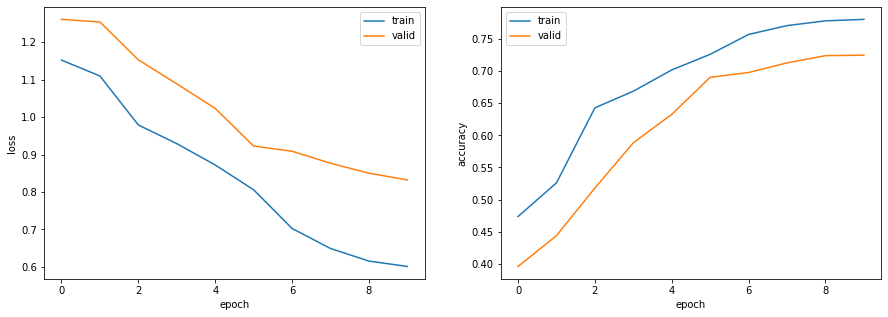

In [39]:
# ログの可視化
visualize_logs(log)

## 84. 単語ベクトルの導入
事前学習済みの単語ベクトル（例えば，Google Newsデータセット（約1,000億単語）での学習済み単語ベクトル）で単語埋め込み$emb(x)$を初期化し，学習せよ．


In [42]:
import gdown  # Download a large file from Google Drive.
# If you use curl/wget, it fails with a large file because of the security warning from Google Drive.
from gensim.models import KeyedVectors

# 学習済み単語ベクトルのダウンロード
url = "https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM"
output = 'GoogleNews-vectors-negative300.bin.gz'
gdown.download(url, output, quiet=True)

# ダウンロードファイルのロード
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

手元のデータの辞書はそのまま利用し、それらの単語ベクトルの初期値としてのみ利用する方法があります。

In [43]:
# 学習済み単語ベクトルの取得
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
weights = np.zeros((VOCAB_SIZE, EMB_SIZE))
words_in_pretrained = 0
for i, word in enumerate(word2id.keys()):
  try:
    weights[i] = model[word]  # 重みの各行に単語辞書の各単語の学習済みベクトルの値を代入していく
    words_in_pretrained += 1
  except KeyError:
    weights[i] = np.random.normal(scale=0.4, size=(EMB_SIZE,))
weights = torch.from_numpy(weights.astype((np.float32)))  # pytorchの型に変換

print(f'学習済みベクトル利用単語数: {words_in_pretrained} / {VOCAB_SIZE}')
print(weights.size())

学習済みベクトル利用単語数: 6746 / 7617
torch.Size([7617, 300])


In [44]:
import gc
del model
gc.collect()

129

次の問題用に双方向化、多層化のための設定も追加

In [47]:
class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size, num_layers, emb_weights=None, bidirectional=False):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.num_directions = bidirectional + 1  # 単方向：1、双方向：2
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)  # エンベディングの重みがあるならvocab_sizeとemb_sizeは自明
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.rnn = nn.RNN(emb_size, hidden_size, num_layers, nonlinearity='tanh', bidirectional=bidirectional, batch_first=True)
    self.fc = nn.Linear(hidden_size * self.num_directions, output_size)

  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden()  # h0のゼロベクトルを作成
    emb = self.emb(x)
    # emb.size() = (batch_size, seq_len, emb_size)
    out, hidden = self.rnn(emb, hidden)
    # out.size() = (batch_size, seq_len, hidden_size * num_directions)
    out = self.fc(out[:, -1, :])
    # out.size() = (batch_size, output_size)
    return out

  def init_hidden(self):
    hidden = torch.zeros(self.num_layers * self.num_directions, self.batch_size, self.hidden_size).to(device)
    return hidden

## 85. 双方向RNN・多層化
順方向と逆方向のRNNの両方を用いて入力テキストをエンコードし，モデルを学習せよ．

$$
\overleftarrow h_{T+1} = 0, \\
\overleftarrow h_t = {\rm \overleftarrow{RNN}}(\mathrm{emb}(x_t), \overleftarrow h_{t+1}), \\
y = {\rm softmax}(W^{(yh)} [\overrightarrow h_T; \overleftarrow h_1] + b^{(y)})
$$

ただし，$\overrightarrow h_t \in \mathbb{R}^{d_h}, \overleftarrow h_t \in \mathbb{R}^{d_h}$はそれぞれ，順方向および逆方向のRNNで求めた時刻$t$の隠れ状態ベクトル，${\rm \overleftarrow{RNN}}(x,h)$は入力$x$と次時刻の隠れ状態$h$から前状態を計算するRNNユニット，$W^{(yh)} \in \mathbb{R}^{L \times 2d_h}$は隠れ状態ベクトルからカテゴリを予測するための行列，$b^{(y)} \in \mathbb{R}^{L}$はバイアス項である．また，$[a; b]$はベクトル$a$と$b$の連結を表す。

さらに，双方向RNNを多層化して実験せよ．


双方向を指定する引数であるbidirectionalをTrueとし、またNUM_LAYERSを2に設定して学習を実行します

In [48]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 2
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weights, bidirectional=True)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.0811, accuracy_train: 0.5682, loss_valid: 1.1617, accuracy_valid: 0.4933, 3.2957sec
epoch: 2, loss_train: 1.0352, accuracy_train: 0.6060, loss_valid: 1.0732, accuracy_valid: 0.5637, 3.2757sec
epoch: 3, loss_train: 1.0013, accuracy_train: 0.6367, loss_valid: 1.1035, accuracy_valid: 0.5750, 3.2748sec
epoch: 4, loss_train: 0.9191, accuracy_train: 0.6792, loss_valid: 1.0191, accuracy_valid: 0.6184, 3.3011sec
epoch: 5, loss_train: 1.0260, accuracy_train: 0.5614, loss_valid: 1.0318, accuracy_valid: 0.6012, 3.2206sec
epoch: 6, loss_train: 0.9016, accuracy_train: 0.6806, loss_valid: 1.1431, accuracy_valid: 0.5352, 3.3088sec
epoch: 7, loss_train: 0.8725, accuracy_train: 0.6922, loss_valid: 1.0280, accuracy_valid: 0.6162, 3.2731sec
epoch: 8, loss_train: 0.8735, accuracy_train: 0.6905, loss_valid: 0.9898, accuracy_valid: 0.6394, 3.2596sec
epoch: 9, loss_train: 0.8557, accuracy_train: 0.6964, loss_valid: 0.9990, accuracy_valid: 0.6334, 3.2473sec
epoch: 10, loss_train: 0.855

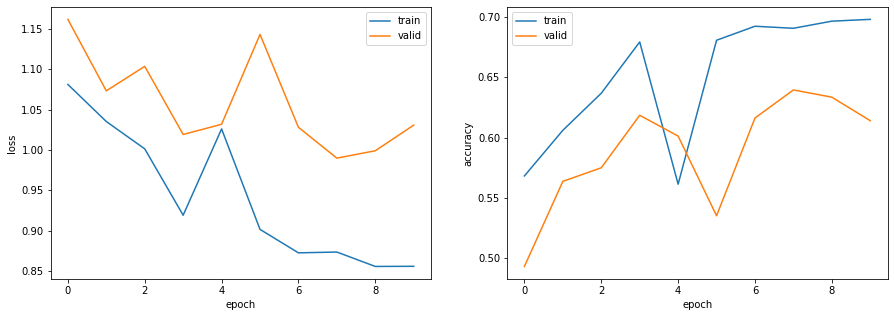

In [49]:
# ログの可視化
visualize_logs(log)

## 86. 畳み込みニューラルネットワーク (CNN)
>ID番号で表現された単語列$\boldsymbol x = (x_1, x_2, \dots, x_T)$がある．ただし，$T$は単語列の長さ，$x_t \in \mathbb{R}^{V}$は単語のID番号のone-hot表記である（$V$は単語の総数である）．畳み込みニューラルネットワーク（CNN: Convolutional Neural Network）を用い，単語列$\boldsymbol x$からカテゴリ$y$を予測するモデルを実装せよ．
>
>ただし，畳み込みニューラルネットワークの構成は以下の通りとする．
>
>+ 単語埋め込みの次元数: $d_w$
+ 畳み込みのフィルターのサイズ: 3 トークン
+ 畳み込みのストライド: 1 トークン
+ 畳み込みのパディング: あり
+ 畳み込み演算後の各時刻のベクトルの次元数: $d_h$
+ 畳み込み演算後に最大値プーリング（max pooling）を適用し，入力文を$d_h$次元の隠れベクトルで表現
 すなわち，時刻$t$の特徴ベクトル$p_t \in \mathbb{R}^{d_h}$は次式で表される．
>
>$$
p_t = g(W^{(px)} [\mathrm{emb}(x_{t-1}); \mathrm{emb}(x_t); \mathrm{emb}(x_{t+1})] + b^{(p)})
]
$$
>
>ただし，$W^{(px)} \in \mathbb{R}^{d_h \times 3d_w}, b^{(p)} \in \mathbb{R}^{d_h}$はCNNのパラメータ，$g$は活性化関数（例えば$\tanh$やReLUなど），$[a; b; c]$はベクトル$a, b, c$の連結である．なお，行列$W^{(px)}$の列数が$3d_w$になるのは，3個のトークンの単語埋め込みを連結したものに対して，線形変換を行うためである．
最大値プーリングでは，特徴ベクトルの次元毎に全時刻における最大値を取り，入力文書の特徴ベクトル$c \in \mathbb{R}^{d_h}$を求める．$c[i]$でベクトル$c$の$i$番目の次元の値を表すことにすると，最大値プーリングは次式で表される．
>
>$$
c[i] = \max_{1 \leq t \leq T} p_t[i]
$$
>
>最後に，入力文書の特徴ベクトル$c$に行列$W^{(yc)} \in \mathbb{R}^{L \times d_h}$とバイアス項$b^{(y)} \in \mathbb{R}^{L}$による線形変換とソフトマックス関数を適用し，カテゴリ$y$を予測する．
>
>$$
y = {\rm softmax}(W^{(yc)} c + b^{(y)})
$$
>
>なお，この問題ではモデルの学習を行わず，ランダムに初期化された重み行列で$y$を計算するだけでよい．

つまり、単語IDを単語ベクトル化したトークン(長さ3dw)を３つ分まとめて線形変換し、活性化関数に通して長さdhの隠れ状態ベクトルを作る。その操作を３連続するすべての単語間(T組ある)で行って、T個の隠れ状態ベクトルを作る。そのT個の各次元の値を見比べて、最も大きいものを１つずつ取り出したものを文書全体の隠れ状態ベクトルcとみなす。最後に、cを線形変換とソフトマックスして各カテゴリの確率を導く。  
畳み込みとは言うけど、画像における畳み込みとは計算方法が違うように見える。  
☆ただ、単語ベクトルの列の各次元の値を１画素とみなして、パディングサイズを単語ベクトルのサイズ３つ分にすれば、畳み込みと解釈できる?

In [50]:
from torch.nn import functional as F

class CNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, kernel_heights, stride, padding, emb_weights=None):
    super().__init__()
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    # 1 input channel, 100 output channels(フィルタ数), 3x300 square(フィルタサイズ)
    # 入力は(バッチ数無視すると) 単語列数(T) × 単語ベクトルサイズ(emb_size)なので、3 × emb_size のフィルタを使う(かつstrideが1)と、下方向にのみフィルタを１つずつズラしていく操作となる
      # 全体にフィルタを通したあとの出力は(T,1)になる（T × 300 → T × 1）
      # フィルタ数が100個なので、その出力が100個分できる(100 × T × 1)
    self.conv = nn.Conv2d(1, out_channels, (kernel_heights, emb_size), stride, (padding, 0))
    self.drop = nn.Dropout(0.3)
    self.fc = nn.Linear(out_channels, output_size)

  def forward(self, x):
    # x.size() = (batch_size, seq_len)  # (バッチサイズ, 単語ID番号がT個並ぶ？)
    emb = self.emb(x).unsqueeze(1)
    # emb.size() = (batch_size, 1, seq_len, emb_size)
    conv = self.conv(emb)
    # conv.size() = (batch_size, out_channels, seq_len, 1)
    act = F.relu(conv.squeeze(3))
    # act.size() = (batch_size, out_channels, seq_len)
    max_pool = F.max_pool1d(act, act.size()[2])  # seq_len方向に最大値を取得
    # max_pool.size() = (batch_size, out_channels, 1)
    out = self.fc(self.drop(max_pool.squeeze(2)))
    # out.size() = (batch_size, output_size)
    return out

In [51]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1

# モデルの定義
model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

# 先頭10件の予測値取得
for i in range(10):
  X = dataset_train[i]['inputs']
  print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.2027, 0.2634, 0.2842, 0.2498]], grad_fn=<SoftmaxBackward>)
tensor([[0.2222, 0.2866, 0.2612, 0.2300]], grad_fn=<SoftmaxBackward>)
tensor([[0.2204, 0.3072, 0.2874, 0.1849]], grad_fn=<SoftmaxBackward>)
tensor([[0.2083, 0.2923, 0.2741, 0.2253]], grad_fn=<SoftmaxBackward>)
tensor([[0.1958, 0.3205, 0.2731, 0.2106]], grad_fn=<SoftmaxBackward>)
tensor([[0.2232, 0.3323, 0.2651, 0.1794]], grad_fn=<SoftmaxBackward>)
tensor([[0.2214, 0.3006, 0.2892, 0.1889]], grad_fn=<SoftmaxBackward>)
tensor([[0.2493, 0.2414, 0.2821, 0.2273]], grad_fn=<SoftmaxBackward>)
tensor([[0.2129, 0.2728, 0.3012, 0.2131]], grad_fn=<SoftmaxBackward>)
tensor([[0.2254, 0.2830, 0.3143, 0.1773]], grad_fn=<SoftmaxBackward>)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


## 87. 確率的勾配降下法によるCNNの学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題86で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ

In [52]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 64
NUM_EPOCHS = 10

# モデルの定義
model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.0484, accuracy_train: 0.5877, loss_valid: 1.0655, accuracy_valid: 0.5840, 1.3738sec
epoch: 2, loss_train: 0.9867, accuracy_train: 0.6642, loss_valid: 1.0135, accuracy_valid: 0.6499, 1.3184sec
epoch: 3, loss_train: 0.9173, accuracy_train: 0.6979, loss_valid: 0.9556, accuracy_valid: 0.6754, 1.3108sec
epoch: 4, loss_train: 0.8556, accuracy_train: 0.7178, loss_valid: 0.9042, accuracy_valid: 0.6904, 1.3461sec
epoch: 5, loss_train: 0.8063, accuracy_train: 0.7268, loss_valid: 0.8640, accuracy_valid: 0.6994, 1.2931sec
epoch: 6, loss_train: 0.7761, accuracy_train: 0.7330, loss_valid: 0.8464, accuracy_valid: 0.6934, 1.3057sec
epoch: 7, loss_train: 0.7472, accuracy_train: 0.7439, loss_valid: 0.8206, accuracy_valid: 0.7106, 1.3074sec
epoch: 8, loss_train: 0.7338, accuracy_train: 0.7479, loss_valid: 0.8111, accuracy_valid: 0.7144, 1.3170sec
epoch: 9, loss_train: 0.7278, accuracy_train: 0.7490, loss_valid: 0.8067, accuracy_valid: 0.7144, 1.3111sec
epoch: 10, loss_train: 0.726

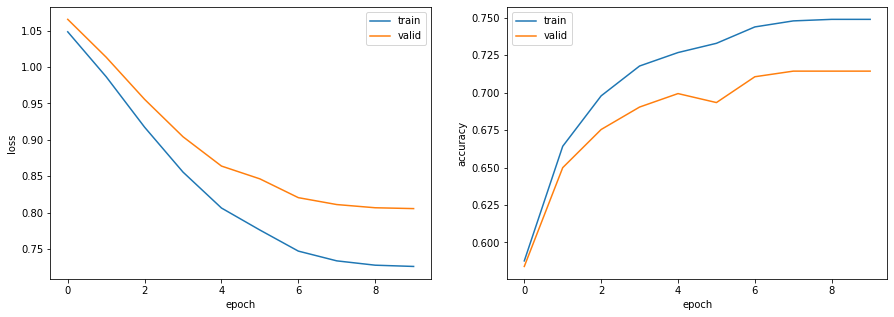

In [54]:
# ログの可視化
visualize_logs(log)

## 88. パラメータチューニング

問題85や問題87のコードを改変し，ニューラルネットワークの形状やハイパーパラメータを調整しながら，高性能なカテゴリ分類器を構築せよ．

In [68]:
# dataloader読み込みver

def calculate_loss_and_accuracy(model, dataloader, device=None, loss_fn=None):
    total_loss = len(dataloader)  # バッチ数(損失はバッチ毎(1イテレータ)に1つ求まるので)
    total_data = dataloader.batch_size * len(dataloader)  # ※全データ =  (バッチ内のデータ数) * (バッチ数)
                                  # 予測結果はバッチ毎に、バッチ内のデータ数だけ求まる
    correct, loss = 0, 0

    with torch.no_grad():  # テスト中は伝播記録をしない
        for data in dataloader:
            inputs = data['inputs'].to(device)
            labels = data['labels'].to(device)         
            pred = model(inputs)
            loss += loss_fn(pred, labels).item()  # バッチ内に複数データがあるなら、各データの損失の平均を返す?
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

    return loss / total_loss, correct / total_data 

In [55]:
from torch.nn import functional as F

class textCNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, conv_params, drop_rate, emb_weights=None):
    super().__init__()
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.convs = nn.ModuleList([nn.Conv2d(1, out_channels, (kernel_height, emb_size), padding=(padding, 0)) for kernel_height, padding in conv_params])
    self.drop = nn.Dropout(drop_rate)
    self.fc = nn.Linear(len(conv_params) * out_channels, output_size)

  def forward(self, x):
    # x.size() = (batch_size, seq_len)
    emb = self.emb(x).unsqueeze(1)
    # emb.size() = (batch_size, 1, seq_len, emb_size)
    conv = [F.relu(conv(emb)).squeeze(3) for i, conv in enumerate(self.convs)]  # こうやって複数のフィルタサイズの畳み込みを同時に試す
    # conv[i].size() = (batch_size, out_channels, seq_len + padding * 2 - kernel_height + 1)
    max_pool = [F.max_pool1d(i, i.size(2)) for i in conv]
    # max_pool[i].size() = (batch_size, out_channels, 1) -> seq_len方向に最大値を取得
    max_pool_cat = torch.cat(max_pool, 1)
    # max_pool_cat.size() = (batch_size, len(conv_params) * out_channels, 1)  -> フィルター別の結果を結合
    out = self.fc(self.drop(max_pool_cat.squeeze(2)))
    # out.size() = (batch_size, output_size)
    return out

In [ ]:
!pip install optuna

In [70]:
import optuna

def objective(trial):
  # チューニング対象パラメータのセット
  emb_size = int(trial.suggest_discrete_uniform('emb_size', 100, 400, 100))
  out_channels = int(trial.suggest_discrete_uniform('out_channels', 50, 200, 50))
  drop_rate = trial.suggest_discrete_uniform('drop_rate', 0.0, 0.5, 0.1)
  learning_rate = trial.suggest_loguniform('learning_rate', 5e-4, 5e-2)
  momentum = trial.suggest_discrete_uniform('momentum', 0.5, 0.9, 0.1)
  batch_size = int(trial.suggest_discrete_uniform('batch_size', 16, 128, 16))

  # 固定パラメータの設定
  VOCAB_SIZE = len(set(word2id.values())) + 1
  PADDING_IDX = len(set(word2id.values()))
  OUTPUT_SIZE = 4
  CONV_PARAMS = [[2, 0], [3, 1], [4, 2]]
  NUM_EPOCHS = 30

  # モデルの定義
  model = textCNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, out_channels, CONV_PARAMS, drop_rate, emb_weights=weights)

  # 損失関数の定義
  criterion = nn.CrossEntropyLoss()

  # オプティマイザの定義
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

  # デバイスの指定
  device = torch.device('cuda')

  # モデルの学習
  log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

  # 損失の算出
  dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)
  loss_valid, _ = calculate_loss_and_accuracy(model, dataloader_valid, device, loss_fn=criterion) 

  return loss_valid 

パラメータ探索を実行します。

In [71]:
# 最適化
study = optuna.create_study()
study.optimize(objective, timeout=300)

# 結果の表示
print('Best trial:')
trial = study.best_trial
print('  Value: {:.3f}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
  print('    {}: {}'.format(key, value))

[I 2021-07-13 06:48:50,268] A new study created in memory with name: no-name-340271ab-f492-48aa-92b2-f744c17c70b3


epoch: 1, loss_train: 1.0992, accuracy_train: 0.5621, loss_valid: 1.1073, accuracy_valid: 0.5510, 2.2056sec
epoch: 2, loss_train: 1.0605, accuracy_train: 0.5824, loss_valid: 1.0761, accuracy_valid: 0.5780, 2.1860sec
epoch: 3, loss_train: 1.0362, accuracy_train: 0.5848, loss_valid: 1.0572, accuracy_valid: 0.5877, 2.1650sec
epoch: 4, loss_train: 1.0125, accuracy_train: 0.6040, loss_valid: 1.0368, accuracy_valid: 0.5982, 2.2043sec
epoch: 5, loss_train: 0.9873, accuracy_train: 0.6422, loss_valid: 1.0161, accuracy_valid: 0.6274, 2.1712sec
epoch: 6, loss_train: 0.9615, accuracy_train: 0.6671, loss_valid: 0.9986, accuracy_valid: 0.6432, 2.1831sec
epoch: 7, loss_train: 0.9354, accuracy_train: 0.6699, loss_valid: 0.9744, accuracy_valid: 0.6447, 2.1691sec
epoch: 8, loss_train: 0.9088, accuracy_train: 0.6867, loss_valid: 0.9523, accuracy_valid: 0.6589, 2.1772sec
epoch: 9, loss_train: 0.8824, accuracy_train: 0.7015, loss_valid: 0.9344, accuracy_valid: 0.6687, 2.1784sec
epoch: 10, loss_train: 0.856

[I 2021-07-13 06:49:56,991] Trial 0 finished with value: 0.7883979455165417 and parameters: {'emb_size': 200.0, 'out_channels': 100.0, 'drop_rate': 0.30000000000000004, 'learning_rate': 0.003700617905438782, 'momentum': 0.6, 'batch_size': 32.0}. Best is trial 0 with value: 0.7883979455165417.


epoch: 1, loss_train: 1.1894, accuracy_train: 0.5260, loss_valid: 1.1870, accuracy_valid: 0.5150, 1.5425sec
epoch: 2, loss_train: 1.1487, accuracy_train: 0.5508, loss_valid: 1.1503, accuracy_valid: 0.5277, 1.5449sec
epoch: 3, loss_train: 1.1278, accuracy_train: 0.5512, loss_valid: 1.1314, accuracy_valid: 0.5345, 1.5416sec
epoch: 4, loss_train: 1.1106, accuracy_train: 0.5560, loss_valid: 1.1170, accuracy_valid: 0.5600, 1.5372sec
epoch: 5, loss_train: 1.0968, accuracy_train: 0.5591, loss_valid: 1.1064, accuracy_valid: 0.5547, 1.5623sec
epoch: 6, loss_train: 1.0870, accuracy_train: 0.5630, loss_valid: 1.0977, accuracy_valid: 0.5675, 1.5355sec
epoch: 7, loss_train: 1.0792, accuracy_train: 0.5667, loss_valid: 1.0914, accuracy_valid: 0.5682, 1.5391sec
epoch: 8, loss_train: 1.0728, accuracy_train: 0.5703, loss_valid: 1.0863, accuracy_valid: 0.5750, 1.5303sec
epoch: 9, loss_train: 1.0678, accuracy_train: 0.5714, loss_valid: 1.0816, accuracy_valid: 0.5810, 1.5560sec
epoch: 10, loss_train: 1.062

[I 2021-07-13 06:50:44,507] Trial 1 finished with value: 1.0516795721435654 and parameters: {'emb_size': 400.0, 'out_channels': 50.0, 'drop_rate': 0.1, 'learning_rate': 0.003312880042964734, 'momentum': 0.6, 'batch_size': 128.0}. Best is trial 0 with value: 0.7883979455165417.


epoch: 1, loss_train: 1.2392, accuracy_train: 0.4264, loss_valid: 1.2372, accuracy_valid: 0.4010, 1.6540sec
epoch: 2, loss_train: 1.1937, accuracy_train: 0.4776, loss_valid: 1.1916, accuracy_valid: 0.4460, 1.7041sec
epoch: 3, loss_train: 1.1739, accuracy_train: 0.5063, loss_valid: 1.1732, accuracy_valid: 0.4685, 1.6651sec
epoch: 4, loss_train: 1.1631, accuracy_train: 0.5211, loss_valid: 1.1637, accuracy_valid: 0.4828, 1.6652sec
epoch: 5, loss_train: 1.1549, accuracy_train: 0.5294, loss_valid: 1.1573, accuracy_valid: 0.4955, 1.6933sec
epoch: 6, loss_train: 1.1534, accuracy_train: 0.5346, loss_valid: 1.1524, accuracy_valid: 0.5007, 1.6773sec
epoch: 7, loss_train: 1.1485, accuracy_train: 0.5363, loss_valid: 1.1482, accuracy_valid: 0.4978, 1.6775sec
epoch: 8, loss_train: 1.1403, accuracy_train: 0.5387, loss_valid: 1.1445, accuracy_valid: 0.5015, 1.6378sec
epoch: 9, loss_train: 1.1397, accuracy_train: 0.5404, loss_valid: 1.1410, accuracy_valid: 0.5007, 1.6510sec
epoch: 10, loss_train: 1.133

[I 2021-07-13 06:51:35,318] Trial 2 finished with value: 1.115865707553845 and parameters: {'emb_size': 200.0, 'out_channels': 150.0, 'drop_rate': 0.1, 'learning_rate': 0.0005344124187496943, 'momentum': 0.6, 'batch_size': 96.0}. Best is trial 0 with value: 0.7883979455165417.


epoch: 1, loss_train: 1.0453, accuracy_train: 0.5903, loss_valid: 1.0629, accuracy_valid: 0.5900, 1.5573sec
epoch: 2, loss_train: 0.9712, accuracy_train: 0.6584, loss_valid: 1.0083, accuracy_valid: 0.6477, 1.6368sec
epoch: 3, loss_train: 0.8748, accuracy_train: 0.6985, loss_valid: 0.9277, accuracy_valid: 0.6814, 1.5622sec
epoch: 4, loss_train: 0.7823, accuracy_train: 0.7300, loss_valid: 0.8602, accuracy_valid: 0.7031, 1.5546sec
epoch: 5, loss_train: 0.6972, accuracy_train: 0.7525, loss_valid: 0.7957, accuracy_valid: 0.7159, 1.6015sec
epoch: 6, loss_train: 0.6293, accuracy_train: 0.7710, loss_valid: 0.7565, accuracy_valid: 0.7249, 1.5650sec
epoch: 7, loss_train: 0.5551, accuracy_train: 0.7935, loss_valid: 0.7164, accuracy_valid: 0.7354, 1.5590sec
epoch: 8, loss_train: 0.5008, accuracy_train: 0.8191, loss_valid: 0.6893, accuracy_valid: 0.7489, 1.5640sec
epoch: 9, loss_train: 0.4504, accuracy_train: 0.8537, loss_valid: 0.6592, accuracy_valid: 0.7601, 1.5564sec
epoch: 10, loss_train: 0.403

[I 2021-07-13 06:52:23,638] Trial 3 finished with value: 0.5256779955427319 and parameters: {'emb_size': 100.0, 'out_channels': 100.0, 'drop_rate': 0.0, 'learning_rate': 0.011668799131382964, 'momentum': 0.9, 'batch_size': 128.0}. Best is trial 3 with value: 0.5256779955427319.


epoch: 1, loss_train: 1.0896, accuracy_train: 0.5547, loss_valid: 1.0961, accuracy_valid: 0.5465, 2.1939sec
epoch: 2, loss_train: 1.0527, accuracy_train: 0.5749, loss_valid: 1.0650, accuracy_valid: 0.5907, 2.2532sec
epoch: 3, loss_train: 1.0269, accuracy_train: 0.5937, loss_valid: 1.0501, accuracy_valid: 0.5750, 2.2130sec
epoch: 4, loss_train: 0.9981, accuracy_train: 0.6316, loss_valid: 1.0231, accuracy_valid: 0.6177, 2.2323sec
epoch: 5, loss_train: 0.9692, accuracy_train: 0.6672, loss_valid: 1.0020, accuracy_valid: 0.6469, 2.2019sec
epoch: 6, loss_train: 0.9378, accuracy_train: 0.6638, loss_valid: 0.9727, accuracy_valid: 0.6417, 2.1986sec
epoch: 7, loss_train: 0.9030, accuracy_train: 0.6926, loss_valid: 0.9493, accuracy_valid: 0.6679, 2.2479sec
epoch: 8, loss_train: 0.8705, accuracy_train: 0.7039, loss_valid: 0.9232, accuracy_valid: 0.6717, 2.2174sec
epoch: 9, loss_train: 0.8399, accuracy_train: 0.7129, loss_valid: 0.8992, accuracy_valid: 0.6739, 2.2288sec
epoch: 10, loss_train: 0.810

[I 2021-07-13 06:53:31,162] Trial 4 finished with value: 0.7507460635330673 and parameters: {'emb_size': 400.0, 'out_channels': 150.0, 'drop_rate': 0.2, 'learning_rate': 0.005256849316592947, 'momentum': 0.5, 'batch_size': 32.0}. Best is trial 3 with value: 0.5256779955427319.


epoch: 1, loss_train: 1.0618, accuracy_train: 0.5624, loss_valid: 1.0756, accuracy_valid: 0.5622, 1.6840sec
epoch: 2, loss_train: 1.0138, accuracy_train: 0.6273, loss_valid: 1.0420, accuracy_valid: 0.6229, 1.6888sec
epoch: 3, loss_train: 0.9593, accuracy_train: 0.6669, loss_valid: 0.9964, accuracy_valid: 0.6552, 1.7029sec
epoch: 4, loss_train: 0.8993, accuracy_train: 0.6841, loss_valid: 0.9483, accuracy_valid: 0.6649, 1.7136sec
epoch: 5, loss_train: 0.8378, accuracy_train: 0.7133, loss_valid: 0.9004, accuracy_valid: 0.6814, 1.6843sec
epoch: 6, loss_train: 0.7811, accuracy_train: 0.7351, loss_valid: 0.8616, accuracy_valid: 0.6979, 1.6987sec
epoch: 7, loss_train: 0.7278, accuracy_train: 0.7510, loss_valid: 0.8251, accuracy_valid: 0.7046, 1.7014sec
epoch: 8, loss_train: 0.6829, accuracy_train: 0.7627, loss_valid: 0.7944, accuracy_valid: 0.7136, 1.7130sec
epoch: 9, loss_train: 0.6432, accuracy_train: 0.7713, loss_valid: 0.7712, accuracy_valid: 0.7241, 1.7095sec
epoch: 10, loss_train: 0.605

[I 2021-07-13 06:54:22,996] Trial 5 finished with value: 0.6206952978406254 and parameters: {'emb_size': 100.0, 'out_channels': 100.0, 'drop_rate': 0.0, 'learning_rate': 0.02218792194617958, 'momentum': 0.5, 'batch_size': 80.0}. Best is trial 3 with value: 0.5256779955427319.


Best trial:
  Value: 0.526
  Params: 
    emb_size: 100.0
    out_channels: 100.0
    drop_rate: 0.0
    learning_rate: 0.011668799131382964
    momentum: 0.9
    batch_size: 128.0


## 89.事前学習済み言語モデルからの転移学習
>事前学習済み言語モデル（例えばBERTなど）を出発点として，ニュース記事見出しをカテゴリに分類するモデルを構築せよ．

BERTモデルを利用するためにtransformersライブラリをインストールしておきます。transformersを通じて、BERT以外にも多くの事前学習済みモデルを短いコードで非常に簡単に利用することができます。

In [6]:
!pip install transformers

     |████████████████████████████████| 2.5MB 4.0MB/s 
     |████████████████████████████████| 901kB 33.1MB/s 
     |████████████████████████████████| 3.3MB 35.0MB/s 


モデルの学習と評価に必要なライブラリをインポートします。

In [8]:
import numpy as np
import transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torch import optim
from torch import cuda
import time
from matplotlib import pyplot as plt

次に、データをモデルに投入可能な形に整形します。  
まずは、PyTorchでよく利用される、特徴ベクトルとラベルベクトルを合わせて保持するDatasetを作成するためのクラスを定義します。  
このクラスにtokenizerを渡すことで、入力テキストの前処理を行い、指定した最長系列長までパディングした上で単語IDに変換する処理を実現できるようにしておきます。  
とはいえ、BERT用にすべての処理が書かれたtokenizerそのものは、のちほどtranformersを通じて取得するため、クラス内で必要なものはtokenizerに渡す処理と結果を受け取る処理のみです。

In [35]:
# Datasetの定義
class CreateDataset2(Dataset):
  def __init__(self, X, y, tokenizer, max_len):
    self.X = X
    self.y = y
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):  # len(Dataset)で返す値を指定
    return len(self.y)

  def __getitem__(self, index):  # Dataset[index]で返す値を指定
    text = self.X[index]
    inputs = self.tokenizer.encode_plus(  # 入力テキストの前処理を行い、指定した最長系列長までパディングした上で単語IDに変換
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      pad_to_max_length=True
    )
    ids = inputs['input_ids']
    mask = inputs['attention_mask']

    return {
      'ids': torch.LongTensor(ids),
      'mask': torch.LongTensor(mask),
      'labels': torch.Tensor(self.y[index])
    }

上記を用いてDatasetを作成します。  
なお、英語版事前学習済みモデルとして利用できるBERTは、最高精度を目指した構成であるLARGEと、それよりパラメータの少ないBASE、それらのそれぞれについて小文字のみ（Uncased）と大文字小文字混在（Cased）の4パターンがあります。  
今回は、手軽に試すことができるBASEのUncasedを使っていきます

In [36]:
# 正解ラベルのone-hot化
y_train = pd.get_dummies(train, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_valid = pd.get_dummies(valid, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_test = pd.get_dummies(test, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values

# Datasetの作成
max_len = 20
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
dataset_train = CreateDataset2(train['TITLE'].values.tolist(), y_train, tokenizer, max_len)
dataset_valid = CreateDataset2(valid['TITLE'].values.tolist(), y_valid, tokenizer, max_len)
dataset_test = CreateDataset2(test['TITLE'].values.tolist(), y_test, tokenizer, max_len)

In [37]:
for var in dataset_train[1]:  # 記事の１つ目をgetitem処理した出力  # 辞書オブジェクトをそのままfor文で回すとキーkeyが取得できる
  print(f'  {var}: {dataset_train[1][var]}')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


  ids: tensor([  101, 18921,  2595,  1011,  7922,  9466,  2006,  2149,  3446, 12143,
         2044, 14315,  2368,  7928,   102,     0,     0,     0,     0,     0])
  mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0])
  labels: tensor([1., 0., 0., 0.])


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


入力文字列がidsとしてID系列に変換されていることが確認できます。BERTでは、変換の過程で元の文の文頭と文末に特殊区切り文字である[CLS]と[SEP]がそれぞれ挿入されるため、それらも101と102として系列に含まれています。0はパディングを表します。  
正解ラベルもlabelsとしてone-hot形式で保持しています。  
また、パディングの位置を表すmaskも合わせて保持し、学習時にidsと一緒にモデルに渡せるようにしておきます。

続いて、ネットワークを定義します。  
transfomersを用いることで、BERT部分はまるごとBertModelで表現可能です。その後、分類タスクに対応するため、BERTの出力ベクトルを受け取るドロップアウトと全結合層を定義すれば完成です。

In [87]:
# BERT分類モデルの定義
class BERTClass(torch.nn.Module):
  def __init__(self, drop_rate, otuput_size):
    super().__init__()
    self.bert = BertModel.from_pretrained('bert-base-uncased',return_dict=False)
    self.drop = torch.nn.Dropout(drop_rate)
    self.fc = torch.nn.Linear(768, otuput_size)  # BERTの出力に合わせて768次元を指定

  def forward(self, ids, mask):
    _, out = self.bert(ids, attention_mask=mask)
    # print(out.size())  # (32, 20, 768) # (batch_size, sequence_length, hidden_size)  # 右の出力
    out = self.fc(self.drop(out))## 
    # print(out.size())  # (32, 20, 4)
    return out

### BERT分類モデルの学習

ここまでで、Datasetとネットワークが準備できたため、あとは普段通りの学習ループを作成します。  
ここでは一連の流れをtrain_model関数として定義しています。

In [89]:
def calculate_loss_and_accuracy(model, criterion, loader, device):
  """ 損失・正解率を計算"""
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for data in loader:
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      # 順伝播
      outputs = model(ids, mask)

      # 損失計算
      # print(outputs.size())
      # print(labels.size())
      loss += criterion(outputs, labels).item()

      # 正解率計算
      pred = torch.argmax(outputs, dim=-1).cpu().numpy() # バッチサイズの長さの予測ラベル配列
      labels = torch.argmax(labels, dim=-1).cpu().numpy()  # バッチサイズの長さの正解ラベル配列
      # pred = torch.argmax(outputs, dim=-1)
      # abels = torch.argmax(labels, dim=-1)

      total += len(labels)
      correct += (pred == labels).sum().item()

  return loss / len(loader), correct / total

In [88]:
def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  """モデルの学習を実行し、損失・正解率のログを返す"""
  # デバイスの指定
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for data in dataloader_train:
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      # print(ids.size())
      outputs = model(ids, mask)
      # print(outputs.size())
      # print(labels.size())
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

  return {'train': log_train, 'valid': log_valid}

パラメータを設定して、ファインチューニングを実行します。

In [90]:
# パラメータの設定
DROP_RATE = 0.4
OUTPUT_SIZE = 4
BATCH_SIZE = 32
NUM_EPOCHS = 4
LEARNING_RATE = 2e-5

# モデルの定義
model = BERTClass(DROP_RATE, OUTPUT_SIZE)

# 損失関数の定義
criterion = torch.nn.BCEWithLogitsLoss()

# オプティマイザの定義
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = 'cuda' if cuda.is_available() else 'cpu'

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, device=device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will

epoch: 1, loss_train: 0.0835, accuracy_train: 0.9517, loss_valid: 0.1111, accuracy_valid: 0.9273, 50.6492sec
epoch: 2, loss_train: 0.0433, accuracy_train: 0.9785, loss_valid: 0.0859, accuracy_valid: 0.9453, 50.6518sec
epoch: 3, loss_train: 0.0262, accuracy_train: 0.9880, loss_valid: 0.0813, accuracy_valid: 0.9468, 50.7967sec
epoch: 4, loss_train: 0.0191, accuracy_train: 0.9922, loss_valid: 0.0978, accuracy_valid: 0.9415, 50.6149sec


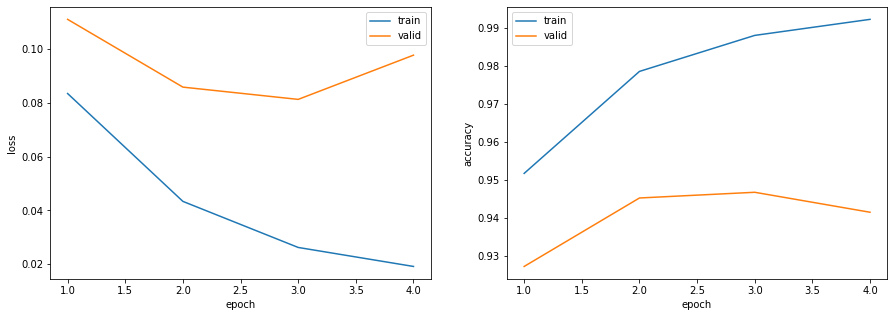

In [91]:
# ログの可視化
x_axis = [x for x in range(1, len(log['train']) + 1)]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x_axis, np.array(log['train']).T[0], label='train')
ax[0].plot(x_axis, np.array(log['valid']).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(x_axis, np.array(log['train']).T[1], label='train')
ax[1].plot(x_axis, np.array(log['valid']).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

In [60]:
# 正解率の算出
def calculate_accuracy(model, dataset, device):
  # Dataloaderの作成
  loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for data in loader:
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      # 順伝播 + 予測値の取得 + 正解数のカウント
      outputs = model.forward(ids, mask)
      pred = torch.argmax(outputs, dim=-1).cpu().numpy()
      labels = torch.argmax(labels, dim=-1).cpu().numpy()
      # pred = torch.argmax(outputs, dim=-1)
      # labels = torch.argmax(labels, dim=-1)
      total += len(labels)
      correct += (pred == labels).sum().item()

  return correct / total

print(f'正解率（学習データ）：{calculate_accuracy(model, dataset_train, device):.3f}')
print(f'正解率（検証データ）：{calculate_accuracy(model, dataset_valid, device):.3f}')
print(f'正解率（評価データ）：{calculate_accuracy(model, dataset_test, device):.3f}')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


torch.Size([10672, 20, 768])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


AttributeError: ignored